<a href="https://colab.research.google.com/github/butchland/fastai_xla_extensions/blob/master/explore_nbs/09_vision_augment_experiments_profile_TPU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#colab
!curl -s https://course.fast.ai/setup/colab | bash

Updating fastai...
Done.


In [2]:
#colab
%%bash
pip install fastai2 --upgrade

In [3]:
#colab
%%bash
pip install git+https://github.com/butchland/fastai_xla_extensions

  Cloning https://github.com/butchland/fastai_xla_extensions to /tmp/pip-req-build-3vd1peu_
  Created wheel for fastai-xla-extensions: filename=fastai_xla_extensions-0.0.1-cp36-none-any.whl size=10373 sha256=77dfaa0d19184b4179a8eea47af0fffd2e7dadbfff83a15814ed017808479030
  Stored in directory: /tmp/pip-ephem-wheel-cache-24hb44_o/wheels/3c/d5/c1/7a96c15b4e74b5d1ec0bc6c29fcaf36501791ce2d9a88a8cea
Successfully built fastai-xla-extensions


  Running command git clone -q https://github.com/butchland/fastai_xla_extensions /tmp/pip-req-build-3vd1peu_


In [4]:
#colab
%%bash
pip install git+https://github.com/butchland/my_timesaver_utils

  Cloning https://github.com/butchland/my_timesaver_utils to /tmp/pip-req-build-gd2y6sb_
  Created wheel for my-timesaver-utils: filename=my_timesaver_utils-0.0.1-cp36-none-any.whl size=9098 sha256=9311dc956d57a25b11a1c6690952b80126b2592bca8066d692ee0a61d95dccf7
  Stored in directory: /tmp/pip-ephem-wheel-cache-77supequ/wheels/ca/6d/f4/ad01bd19bc4c102a3851d9c636dc2a2031d97b98cb9a73effa
Successfully built my-timesaver-utils


  Running command git clone -q https://github.com/butchland/my_timesaver_utils /tmp/pip-req-build-gd2y6sb_


In [5]:
#colab
# install pytorch xla
VERSION = "20200707"  #@param ["1.5" , "20200516","20200707", "nightly"]
!curl https://raw.githubusercontent.com/pytorch/xla/master/contrib/scripts/env-setup.py -o pytorch-xla-env-setup.py
!python pytorch-xla-env-setup.py --version $VERSION

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5115  100  5115    0     0  93000      0 --:--:-- --:--:-- --:--:-- 93000
Updating... This may take around 2 minutes.
Updating TPU runtime to pytorch-dev20200707 ...
     |████████████████████████████████| 61kB 2.1MB/s 
Uninstalling torch-1.6.0+cu101:
  Found existing installation: google-api-python-client 1.7.12
    Uninstalling google-api-python-client-1.7.12:
      Successfully uninstalled google-api-python-client-1.7.12
Done updating TPU runtime
  Successfully uninstalled torch-1.6.0+cu101
Uninstalling torchvision-0.7.0+cu101:
  Successfully uninstalled torchvision-0.7.0+cu101
Copying gs://tpu-pytorch/wheels/torch-nightly+20200707-cp36-cp36m-linux_x86_64.whl...
\ [1 files][107.5 MiB/107.5 MiB]                                                
Operation completed over 1 objects/107.5 MiB.                                    


In [6]:
import os
assert os.environ['COLAB_TPU_ADDR'], 'Make sure to select TPU from Edit > Notebook settings > Hardware accelerator'

In [7]:
%%bash
pip freeze | grep torch
pip freeze | grep fastai2

torch==1.7.0a0+12b5bdc
torch-xla==1.6+5430aca
torchsummary==1.5.1
torchtext==0.3.1
torchvision==0.8.0a0+86b6c3e
fastai2==0.0.21


In [8]:
import fastai_xla_extensions.core

In [9]:
from fastai2.vision.all import *

In [10]:
from my_timesaver_utils.profiling import *

In [11]:
path = untar_data(URLs.PETS)/'images'

In [12]:
Path.BASE_PATH = path; path.ls()

(#7393) [Path('german_shorthaired_97.jpg'),Path('havanese_150.jpg'),Path('Bombay_164.jpg'),Path('Birman_185.jpg'),Path('leonberger_139.jpg'),Path('miniature_pinscher_124.jpg'),Path('saint_bernard_125.jpg'),Path('Birman_80.jpg'),Path('pug_47.jpg'),Path('havanese_77.jpg')...]

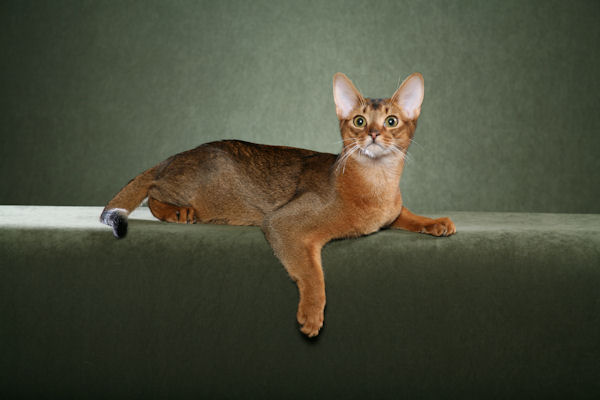

In [13]:
img = PILImage.create(path/'Abyssinian_1.jpg');img

In [14]:
img.shape

(400, 600)

In [15]:
resize = Resize(size=200)

In [16]:
img2 = resize(img,split_idx=0)
img2.shape

(200, 200)

In [17]:
timg2 = TensorImage(array(img2)).permute(2,0,1).float()/255.; timg2.shape

torch.Size([3, 200, 200])

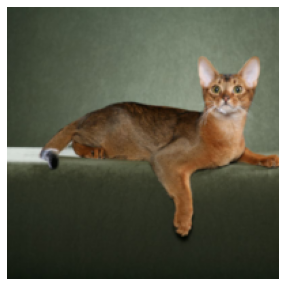

In [18]:
show_image(timg2)

In [19]:
default_device()

device(type='xla', index=1)

In [20]:
torch.cuda.is_available()

False

In [21]:
def batch_ex(bs, device): return TensorImage(timg2[None].to(device).expand(bs, *timg2.shape))

In [22]:
b768_img = batch_ex(768, default_device()); (b768_img.shape, b768_img.device)

(torch.Size([768, 3, 200, 200]), device(type='xla', index=1))

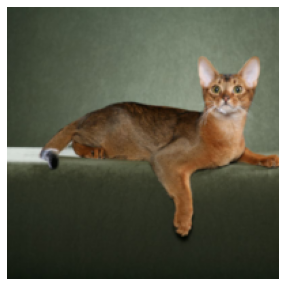

In [23]:
show_image(b768_img[-1].to(torch.device('cpu')));

### Add transform

In [24]:
flip_tfm = Flip(p=1.0); flip_tfm

AffineCoordTfm:
encodes: (TensorBBox,object) -> encodes
(TensorPoint,object) -> encodes
(TensorImage,object) -> encodes
(TensorMask,object) -> encodes
decodes: 

### Add profilers 

In [25]:
F.grid_sample = profile_call(F.grid_sample)

In [26]:
@profile_call
def mtest(b_img):
    #set_trace()
    new_b_img = flip_tfm(b_img)
    return new_b_img

### Profile transform calls

In [27]:
clear_prof_data()

In [28]:
%%time
new_b768_img = mtest(b768_img)

CPU times: user 3.23 s, sys: 1.74 s, total: 4.97 s
Wall time: 8.43 s


In [29]:
print_prof_data()

Function grid_sample called 1 times.
Execution time max: 4.718, average: 4.718
Function mtest called 1 times.
Execution time max: 8.426, average: 8.426


In [30]:
(new_b768_img.shape, new_b768_img.device)

(torch.Size([768, 3, 200, 200]), device(type='xla', index=1))

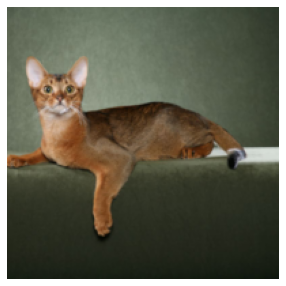

In [31]:
show_image(new_b768_img[-1].to(torch.device('cpu')));

In [ ]:
clear_prof_data()

In [32]:
%%time
for i in range(10): new_b768_img = mtest(b768_img)

CPU times: user 35.3 s, sys: 5.76 s, total: 41.1 s
Wall time: 1min 12s


In [33]:
print_prof_data()

Function grid_sample called 11 times.
Execution time max: 4.718, average: 4.247
Function mtest called 11 times.
Execution time max: 8.426, average: 7.341
